In [1]:
# # 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# !mkdir /home/aistudio/external-libraries
# # 安装pandas到指定目录
# !pip install pandas -t /home/aistudio/external-libraries

# # 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# import sys 
# sys.path.append('/home/aistudio/external-libraries')

In [2]:
#导入需要的包
import os
import numpy as np
from PIL import Image
import cv2
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision.transforms import Compose, Normalize

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [3]:
# 解压

import zipfile
path="/home/aistudio/data/data179734"
os.chdir(path)
extract=zipfile.ZipFile("fish_image.zip")
extract.extractall()

# 一、数据处理

In [4]:
import paddle.vision.transforms as T
transforms = T.Compose([
T.Resize((47,47)), # 随机裁剪大小
T.RandomHorizontalFlip(0.5), # 随机水平翻转
T.ToTensor(), # 数据的格式转换和标准化、 HWC => CHW
T.Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5]) # 图像归一化
])

In [27]:
import paddle
import os
import cv2
import numpy as np
class MyDataset(paddle.io.Dataset):
    """
    继承paddle.io.Dataset类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        初始化数据集
        """
        super(MyDataset, self).__init__()
        self.datalist = []
        with open(label_path, encoding='utf-8') as f:
            for line in f.readlines():  # 对每一行
                image_path, label = line.strip().split("\t")  # 去除去除空白并且从制表符处分裂
                image_path = os.path.join(data_dir, image_path)  # 合并路径生成完整的图片文件路径
                # 将图片的文件路径以及标签组合起来纳入数据列表
                self.datalist.append([image_path, label])
        # 传入定义好的数据处理方法，并且作为一个属性
        self.transform = transform
    
    def __getitem__(self, index):
        """
        完成该函数可以在指定index下标时获取到数据
        """
        image_path, label = self.datalist[index]  # 解包
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 读取单通道的灰度图
        image = image.astype("float32")  # 转换成paddle内部运行时用的数据类型
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = np.array([label],dtype = "int64")
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        实现len函数，返回数据集的样本总数
        """
        return len(self.datalist)

In [30]:
from paddle.vision.transforms import Normalize

train_dataset = MyDataset('./','./train.txt', transforms)
test_dataset = MyDataset('./','./eval.txt', transforms)
print('train_dataset images: ',len(train_dataset), 'test_dataset images: ',len(test_dataset))

train_dataset images:  14550 test_dataset images:  1620


batch_id: 0,images_shape: [64, 3, 47, 47],labels_shape: [64, 1]
train_data 的标签为:2


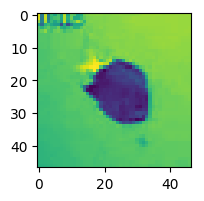

In [31]:
import paddle
import cv2
import matplotlib.pyplot as plt

train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
for batch_id,data in enumerate(train_loader()):
    images, labels = data
    print(f"batch_id: {batch_id},images_shape: {images.shape},labels_shape: {labels.shape}")
    plt.figure(figsize=(2,2))
    plt.imshow(images[0][0])
    print(f'train_data 的标签为:{labels[0].item()}')
    break

# 二、模型设计

In [23]:
import paddle.nn.functional as F
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        """
        in_channels：输入图像的通道数 
        out_channels:输出的通道数
        stride：步长 
        kernel_size：卷积核大小
        """
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5,stride=2)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=3,stride=2)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=200, out_features=5)
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x = F.softmax(x)
        return x
    def save(self,adam):
        # 保存Layer参数
        paddle.save(self.state_dict(),"linear_net.pdparams")
        # 保存优化器参数
        paddle.save(adam.state_dict(),"adam.pdopt")
model = MyCNN()
paddle.summary(model,(1, 3, 47, 47))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-5       [[1, 3, 47, 47]]     [1, 20, 22, 22]         1,520     
  MaxPool2D-5    [[1, 20, 22, 22]]     [1, 20, 11, 11]           0       
   Conv2D-6      [[1, 20, 11, 11]]      [1, 50, 5, 5]          9,050     
  MaxPool2D-6     [[1, 50, 5, 5]]       [1, 50, 2, 2]            0       
   Linear-3          [[1, 200]]             [1, 5]             1,005     
Total params: 11,575
Trainable params: 11,575
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.17
---------------------------------------------------------------------------



{'total_params': 11575, 'trainable_params': 11575}

# 三、模型训练

In [9]:
t_loss = []  # 用于存放train_loss
t_acc = []  # 用于存放train_acc

epochs = 20 # 设置选代次数
optim = paddle.optimizer.Adam(learning_rate=0.002,parameters=model.parameters()) # 设置优化器
loss_fn = paddle.nn.CrossEntropyLoss()
max_acc=0.8 # 初始化保存门槛准确率
for epoch in range(epochs):
    for batch_id, (x_data, y_data) in enumerate(train_loader()):
        predicts = model(x_data)  # 预测结果
        # 计算损失和准确率
        loss = loss_fn(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        # 保存loss和acc
        t_loss.append(loss.numpy())
        t_acc.append(acc.numpy())
        # 反向传递
        loss.backward()
        if (batch_id+1) % 50 == 0:  # 每50个batch
            print(f"epoch_id: {epoch+1}, batch_id: {batch_id+1}, loss is: {loss.numpy()}, acc is: {acc.numpy()}")
            # 看是否比之前更好，如果是则需要保存
            if(acc.numpy()>=max_acc):
                model.save(optim)
                max_acc=acc.numpy()
                print("save")
        # 更新参数
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch_id: 1, batch_id: 50, loss is: [1.1605345], acc is: [0.78125]
epoch_id: 1, batch_id: 100, loss is: [1.0725732], acc is: [0.890625]
save
epoch_id: 1, batch_id: 150, loss is: [1.0933876], acc is: [0.8125]
epoch_id: 1, batch_id: 200, loss is: [1.1407242], acc is: [0.765625]
epoch_id: 2, batch_id: 50, loss is: [1.0232762], acc is: [0.90625]
save
epoch_id: 2, batch_id: 100, loss is: [1.0014703], acc is: [0.90625]
save
epoch_id: 2, batch_id: 150, loss is: [1.0850847], acc is: [0.8125]
epoch_id: 2, batch_id: 200, loss is: [1.0560893], acc is: [0.828125]
epoch_id: 3, batch_id: 50, loss is: [1.0181893], acc is: [0.90625]
save
epoch_id: 3, batch_id: 100, loss is: [1.0128895], acc is: [0.90625]
save
epoch_id: 3, batch_id: 150, loss is: [1.0292209], acc is: [0.859375]
epoch_id: 3, batch_id: 200, loss is: [0.9713514], acc is: [0.921875]
save
epoch_id: 4, batch_id: 50, loss is: [1.0132508], acc is: [0.890625]
epoch_id: 4, batch_id: 100, loss is: [0.97160274], acc is: [0.953125]
save
epoch_id: 4

# 四、模型评估与推理

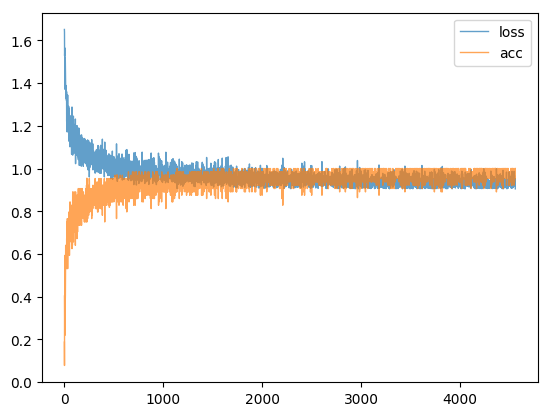

In [14]:
plt.plot(t_loss, label='loss', linewidth = 1, alpha=0.7)
plt.plot(t_acc, label='acc', linewidth = 1, alpha=0.7)
plt.legend()  # 显示对应
plt.show()

In [11]:
def load(layer,adam):
    # 载入模型参数、优化器参数和最后一个epoch保存的检查点
    layer_state_dict = paddle.load("linear_net.pdparams")
    opt_state_dict = paddle.load("adam.pdopt")
    # 将load后的参数与模型关联起来
    layer.set_state_dict(layer_state_dict)
    adam.set_state_dict(opt_state_dict)

batch_id: 5, loss is: [0.95598495], acc is: [0.953125]
batch_id: 10, loss is: [0.94952035], acc is: [0.9375]
batch_id: 15, loss is: [0.90493566], acc is: [1.]
batch_id: 20, loss is: [0.9426518], acc is: [0.96875]
batch_id: 25, loss is: [0.9294113], acc is: [0.96875]


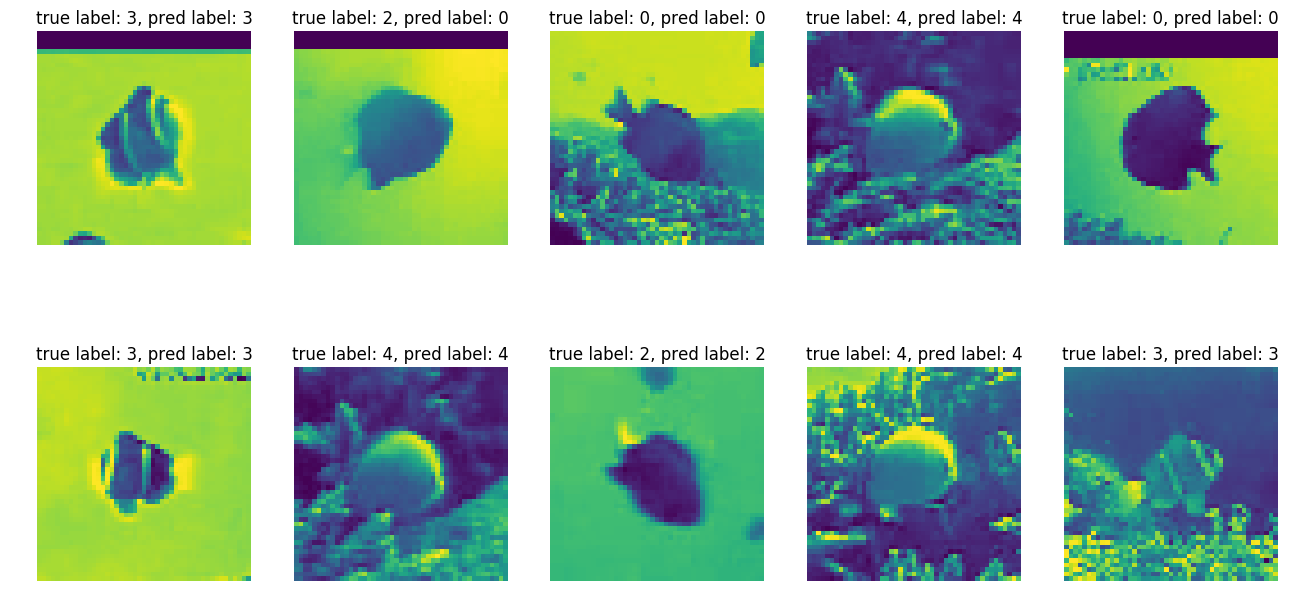

In [51]:
from paddle.io import RandomSampler,BatchSampler
best=MyCNN()
optim = paddle.optimizer.Adam(learning_rate=0.001,parameters=best.parameters()) # 设置优化器
load(best,optim)
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
best.eval()
for batch_id, (x_data, y_data) in enumerate(test_loader()):
    # 测试数据标签
    predicts = best(x_data)
    # 预测结果
    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    # 打印信息
    if (batch_id+1) % 5 == 0:
        print(f"batch_id: {batch_id+1}, loss is: {loss.numpy()}, acc is: {acc.numpy()}")
i=0
plt.figure(figsize=(16,8))
for num, (img, label) in enumerate(test_loader):
    # 执行推理并打印结果
    pred_label = best(img)[i].argmax()
    plt.subplot(2, 5, num+1)
    plt.title(f'true label: {label[i].item()}, pred label: {pred_label[i].item()}')
    plt.imshow(img[i][0])
    plt.axis('off')
    if(num == 9):
        break